In [46]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import re
from tqdm import tqdm
from IPython.display import Image, display
from datetime import date, timedelta
import numpy as np
from matplotlib.pyplot import *
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
batch_size = 96  # *7

def build_area_seqs(target_area, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'generated/data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df)>0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')


def get_nodes_features(area_df):
    node_f = area_df[['total_space','monthly_fee','building_type']]
    node_f.loc[:,['total_space', 'monthly_fee']] = min_max_scaler.fit_transform(node_f[['total_space', 'monthly_fee']])
    building_type_oneHot = pd.get_dummies(node_f['building_type'])
    node_f = node_f.drop('building_type',axis = 1)
    node_f = node_f.join(building_type_oneHot)
    return node_f

def max_min_scale(raw):
    x_scaled = min_max_scaler.fit_transform(raw.numpy())
    return pd.DataFrame(x_scaled)

In [80]:
basic_info_df = pd.read_csv('generated/data/parkings_info.csv')
basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))

from graph_utils import build_graph

target_park = '大信大厦'
use_gcn=False
graph_nodes_max_dis = 0.5 if use_gcn else 0.1

target_area, adj, target_map, nks, kns = build_graph(basic_info_df, target_park, max_dis=graph_nodes_max_dis)
target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]
key = nks[target_park]
node_f = get_nodes_features(target_area)
seqs_raw = build_area_seqs(target_area , start='2016-06-02', end='2016-08-04')
seqs_normal = seqs_raw.copy().fillna(0)
seqs_normal[seqs_normal.columns.values] = min_max_scaler.fit_transform(seqs_normal[seqs_normal.columns.values])

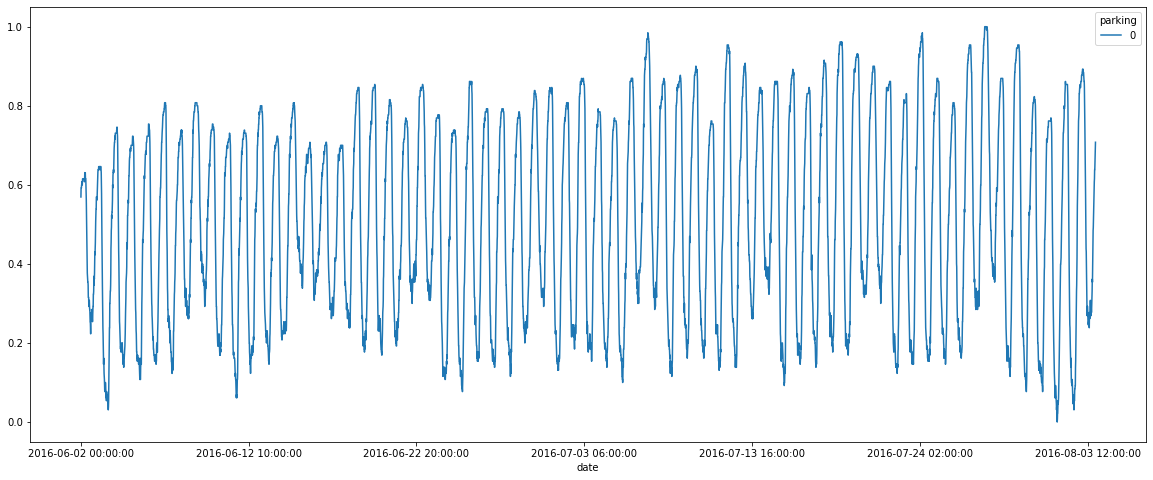

In [81]:
seqs_normal.plot(figsize=(20,8))

In [75]:
import tensorflow as tf
from abc import ABC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GRU, Flatten, Dense, LeakyReLU
from spektral.layers import GraphConv

l2_reg = 5e-4 / 2  # L2 regularization rate


class Generator(Model, ABC):

    def __init__(self, adj, nodes_features, base=8, dropout=0.5):
        super(Generator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.dropout = Dropout(dropout)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(128,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(64,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(256, activation='relu')
        self.dense_2 = Dense(512, activation='relu')
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # N*F
        g = tf.convert_to_tensor(self.adj)  # N*N
        s = tf.convert_to_tensor(seq)  # S*N
        
        if use_gcn:
            c = self.graph_conv_1([f, g])  # N*Cov1
            c = self.graph_conv_2([c, g])  # N*Cov2
            s = tf.matmul(s, c)  # S*N x N*Cov2
        
        fc = self.dense_1(s)  # 96*32
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # 96*32
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)  # 1*96*32
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # 96*32
        return self.final_dense(ro)  # 96*1


class Discriminator(Model, ABC):

    def __init__(self, adj, nodes_features, base=8, dropout=0.5, alpha=0.2):
        super(Discriminator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.leaky_relu = LeakyReLU(alpha=alpha)
        self.dropout = Dropout(dropout)
        self.flatten = Flatten()
        self.graph_conv_1 = GraphConv(128,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.graph_conv_2 = GraphConv(64,
                                      activation='elu',
                                      kernel_regularizer=l2(l2_reg),
                                      use_bias=False)
        self.dense_1 = Dense(256)
        self.dense_2 = Dense(512)
        self.gru = GRU(128, return_sequences=True)
        self.final_dense = Dense(1, activation='sigmoid')

    def call(self, seq, training=True):
        f = tf.convert_to_tensor(self.nodes_features)  # N*F
        g = tf.convert_to_tensor(self.adj)  # N*N
        s = tf.convert_to_tensor(seq)  # S*N
        
        if use_gcn:
            c = self.graph_conv_1([f, g])  # N*Cov1
            c = self.graph_conv_2([c, g])  # N*Cov2
            s = tf.matmul(s, c)  # S*N x N*Cov2
        
        fc = self.dense_1(s)  # S*D1
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # S*D2
        fc = self.leaky_relu(fc)
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # S*G
        return self.final_dense(ro)  # G*1


In [76]:
import os
from tensorflow.keras.optimizers import Adam
from spektral.utils import normalized_laplacian
# from model import Generator, Discriminator
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

save_interval = 5

class Train:
    def __init__(self, seqs, adj, nodes_features, epochs=1000,
                 lr = 1e-3, adam_beta_1 = 0.5, base=8, dropout=0.5, alpha=0.2):
        self.epochs = epochs
        self.seqs = seqs.astype('float32')

        self.gen_optimizer = Adam(lr, adam_beta_1)
        self.desc_optimizer = Adam(lr, adam_beta_1)

        self.adj = normalized_laplacian(adj.astype('float32'))
        self.nodes_features = nodes_features.astype('float32')
        self.generator = Generator(self.adj, self.nodes_features, base, dropout)
        self.discriminator = Discriminator(self.adj, self.nodes_features, base, dropout, alpha)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def __call__(self, epochs=None ,save_path='generated/'):
        save_path += str(time.time())
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if epochs is None:
            epochs = self.epochs
            
        time_len = self.seqs.shape[0]
        num_nodes = self.seqs.shape[1]
        total_batch = int(time_len / batch_size)  # 2976/96=31

        time_consumed_total = 0.
        for epoch in range(1, epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0

            for week in range(0, total_batch):
                current_seqs = self.seqs[week*batch_size:week*batch_size + batch_size]
                seqs_noised = current_seqs.copy()
                max_s = current_seqs[key].max()
                seqs_noised[key] = np.random.normal(max_s / 2.0, max_s / 10.0,
                                                         size=(current_seqs.shape[0])).astype('float32')
                gen_loss, disc_loss = self.train_step(current_seqs, seqs_noised)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            epochs_last = epochs - epoch
            estimate_time_last = epochs_last * time_consumed_agv

            if epoch % save_interval == 0:
                print('epoch {}({})/{}({}) - gen_loss = {}, disc_loss = {}, estimated to finish: {}'
                  .format(epoch, round(time.time() - start, 2),
                          epochs, round(time_consumed_total, 2),
                          round(float(total_gen_loss / total_batch), 5),
                          round(float(total_disc_loss / total_batch), 5),
                          round(estimate_time_last, 2)))
                
                self.compare_plot(str(epoch), save_path)
        
        self.compare_plot(str(epochs)+'_final', save_path, 0, 60)

    @tf.function
    def train_step(self, seqs, seqs_noised):
        with tf.GradientTape(persistent=True) as tape:
            real_output = self.discriminator(seqs)  # 评价高
            generated = self.generator(seqs_noised)
            left = tf.slice(seqs, [0, 0], [batch_size, key])
            right = tf.slice(seqs, [0, key + 1], [batch_size, -1])
            combined = tf.concat([left, generated, right], 1)
            generated_output = self.discriminator(combined)  # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d

    def generate_first(self):
        import random as random
        week = 1 # random.randint(0,31)
        seqs_replace = self.seqs[week*batch_size:week*batch_size + batch_size].copy()
        max_s = seqs_replace[key].max()
        seqs_replace[key] = np.random.normal(max_s / 2.0, max_s / 10.0, size=(seqs_replace.shape[0])).astype(
            'float32')
        gen_data = self.generator(seqs_replace, training=False)
        return max_min_scale(gen_data)

    def generate(self, real_seqs):
        seqs_replace = real_seqs.copy()
        max_s = seqs_replace[key].max()
        seqs_replace[key] = np.random.normal(max_s / 2.0, max_s / 10.0, size=(seqs_replace.shape[0])).astype(
            'float32')
        gen_data = self.generator(seqs_replace, training=False)
        return pd.DataFrame(gen_data.numpy())
    
    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        return loss_object(tf.ones_like(fake_output), fake_output)
    
    def compare_plot(self, name, save_path, start_day=0, days=7):
        fig, ax = subplots()
        fig.set_figheight(8)
        fig.set_figwidth(20)
        real_seqs = self.seqs[start_day:start_day+(days*96)]
        generated_seqs = []
        for d in range(days):
            generated_seq = self.generate(real_seqs[start_day*d:start_day*d+batch_size])
            if len(generated_seqs) == 0:
                generated_seqs = generated_seq
            else:
                generated_seqs =  generated_seqs.append(generated_seq, ignore_index=True)
        all_seqs = pd.concat([pd.DataFrame(real_seqs[key].values), generated_seqs], axis=1)
        all_seqs.plot(ax=ax)
        n=2
        ax.legend(['real'+str(w) for w in range(1,n)]+['gen'+str(w) for w in range(1,n)]);
        fig.savefig(save_path+"/compare_" + name + ".png")
        plt.close()

In [82]:
batch_size = 96*7

lr = 0.0001
adm1 = 0.5
base = 8
epochs=1000
dropout = 0.3
alpha = 0.2
name='GCN_'+str(use_gcn)+'_'+str(lr)+'_'+str(adm1)+'_'+str(dropout)+'_'+str(alpha)
save_path='generated/'+str(epochs)

In [83]:
train = Train(seqs_normal, adj, node_f, epochs, lr = lr, adam_beta_1 = adm1, base=base, dropout=dropout, alpha=alpha)
train(epochs, save_path+'/'+name+'_')

C:\Users\marko\anaconda3\lib\site-packages\spektral\utils\convolution.py:30: RuntimeWarning: divide by zero encountered in power
  degrees = np.power(np.array(A.sum(1)), k).flatten()


epoch 5(6.32)/1000(63.63) - gen_loss = 0.68739, disc_loss = 1.38355, estimated to finish: 12662.77
epoch 10(6.57)/1000(102.25) - gen_loss = 0.68274, disc_loss = 1.37999, estimated to finish: 10122.59
epoch 15(6.56)/1000(140.79) - gen_loss = 0.66524, disc_loss = 1.38825, estimated to finish: 9244.97
epoch 20(6.42)/1000(179.2) - gen_loss = 0.73457, disc_loss = 1.38637, estimated to finish: 8780.62
epoch 25(7.62)/1000(218.33) - gen_loss = 0.67213, disc_loss = 1.39266, estimated to finish: 8515.03
epoch 30(7.48)/1000(257.23) - gen_loss = 0.66705, disc_loss = 1.3712, estimated to finish: 8317.0
epoch 35(7.55)/1000(295.74) - gen_loss = 0.66603, disc_loss = 1.38501, estimated to finish: 8153.85
epoch 40(7.75)/1000(333.62) - gen_loss = 0.6324, disc_loss = 1.36313, estimated to finish: 8006.91
epoch 45(7.82)/1000(371.61) - gen_loss = 0.69045, disc_loss = 1.41118, estimated to finish: 7886.48
epoch 50(7.84)/1000(410.07) - gen_loss = 0.68793, disc_loss = 1.39099, estimated to finish: 7791.3
epoch

KeyboardInterrupt: 